In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [3]:
# Understand Data Content
outputdir = 'D:/MyWorx/Courses/PAF Bootcamp/Challenges/Images/output'
imagesdata = np.load(outputdir+'/'+'images.npy')

In [22]:
print('number of samples: ', len(imagesdata))
print('Image Shape:',imagesdata[:,0][0].shape)
print('Labels: ', np.unique(imagesdata[:,1]))

number of samples:  2112
Image Shape: (128, 128, 3)
Labels:  ['axes' 'boots' 'carabiners' 'crampons' 'gloves' 'hardshell_jackets'
 'harnesses' 'helmets' 'insulated_jackets' 'pulleys' 'rope' 'tents']


In [23]:
Images = imagesdata[:,0]
Labels = imagesdata[:,1]

In [25]:
from sklearn.model_selection import train_test_split

images_Train, images_Test,labels_Train,labels_Test = train_test_split(Images,Labels,test_size=0.2
                                                                     ,shuffle=True,random_state=42)

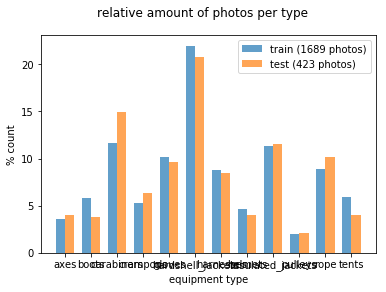

In [28]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5

    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]

    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'

    xtemp = np.arange(len(unique))

    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)

plt.suptitle('relative amount of photos per type')
plot_bar(labels_Train, loc='left')
plot_bar(labels_Test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(labels_Train)),
    'test ({0} photos)'.format(len(labels_Test))]);

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog
from skimage.transform import rescale

class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """returns itself"""
        return self

    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])


class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """

    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)

        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [61]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
import skimage

# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(8, 8),
    cells_per_block=(2,2),
    orientations=9,
    block_norm='L2-Hys'
)
scalify = StandardScaler()

# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(images_Train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)

print(X_train_hog.shape)

(1689, 8100)


In [40]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, labels_Train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)

In [56]:
X_test_gray = grayify.transform(images_Test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)


(423, 8100)


In [45]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == labels_Test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == labels_Test)/len(labels_Test))

[ True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]

Percentage correct:  91.725768321513


(128, 128, 3)


C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


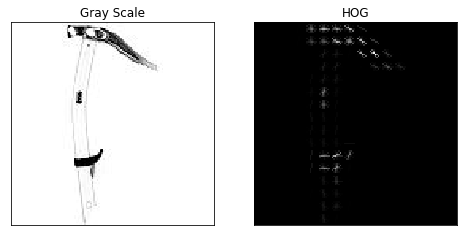

(1, 8100)
Prediction:  ['axes']


In [93]:
from PIL import Image, ImageOps,ImageDraw

mytestimages = 'D:/MyWorx/Courses/PAF Bootcamp/Challenges/Images/test/31AjDH9RQyL._AC_US436_QL65_.jpg'

image_array = np.array(Image.open(mytestimages))

print(image_array.shape)
image_gray = skimage.color.rgb2gray(image_array)
img_hog, img_hog_img = hog(
    image_gray, pixels_per_cell=(8, 8),
    cells_per_block=(2,2),
    orientations=9,
    visualise=True,
    block_norm='L2-Hys')

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    for a in ax]

ax[0].imshow(image_gray, cmap='gray')
ax[0].set_title('Gray Scale')
ax[1].imshow(img_hog_img, cmap='gray')
ax[1].set_title('HOG')
plt.show()

hogshape = np.array(img_hog).reshape(1,8100)
print(hogshape.shape)
imageready = scalify.transform(hogshape)
y_pred = sgd_clf.predict(imageready)

print('Prediction: ',y_pred)

In [97]:
import pickle

pkl_filename = outputdir+'/'+'taditionalImageClassification.pkl'
with open(pkl_filename, 'wb') as file: 
    savedmodel = pickle.dump(sgd_clf,file)